http://cocodataset.org/#download - Датасет, который использовался для тренировки.

В данном ноутбуке описана сеть U-Net, которая состоит из нескольких слоев: 
    * Convoltion
    * Maxpooling
    * Dropout
    * Transposed Convolution
    
__Convolution__ --- обычная свертка, их используется несколько штук. Пусть $K$ --- матрица $(2l+1)\times{}(2l+1)$, ядро свертки. Тогда образ свертки $B$ задается следующим образом (есть различные варианты обработки изображения по краям):

$$B = K * A $$
$$b_{m,n} = \sum_{-l\leq{}i,j\leq{}l}{a_{m+i,n+j}k_{m+i,n+j}} $$

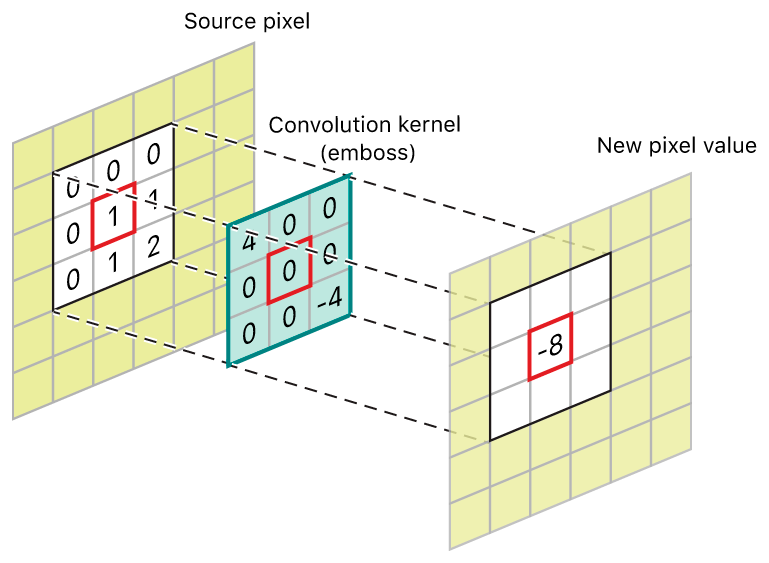


__Maxpooling__ --- слой, где по изображению проходит сканирующее окно, и для каждого своего положения оно отбирает максимальное значение из окна. (Как и в свертке, есть различные способы обработки изображения по краям)

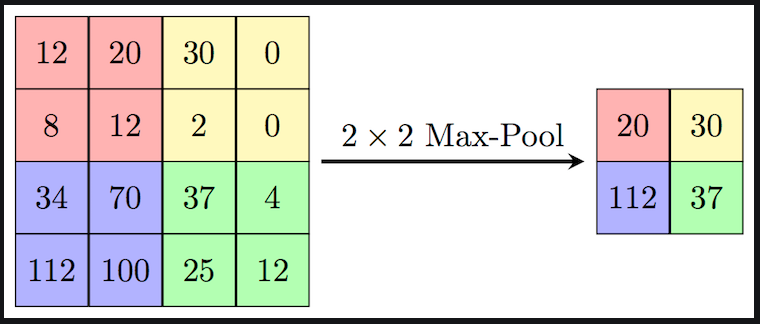

**Dropout** --- этап, когда часть нейронов "выбрасывается" из модели. То есть они больше не учевствуют в тренировке и предсказывании. В первую очередь это делается чтобы предотвратить переобучение на тренировочных данных. 
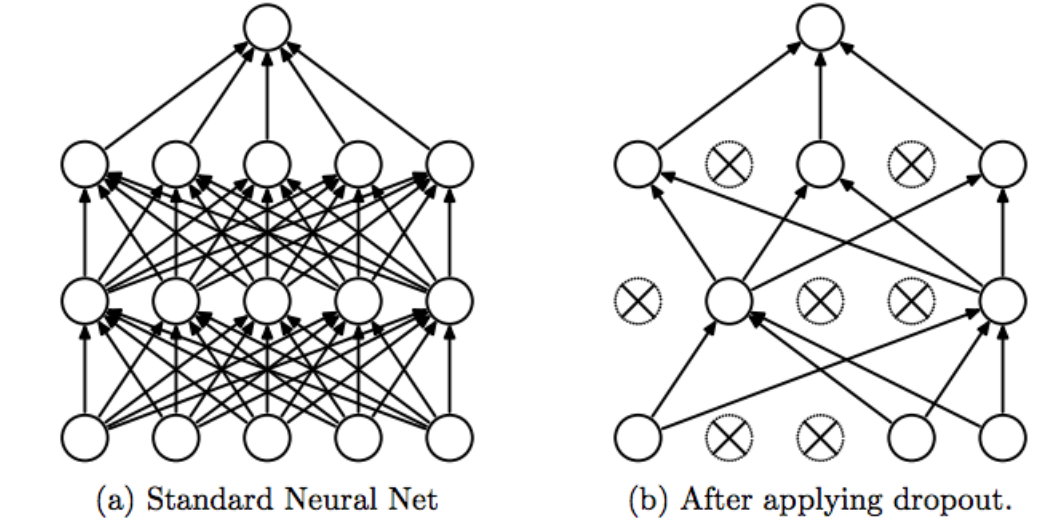

**Transposed convolution** ---   способ получить обратно изображение изначального разрешения после его сжатия. Выучив во время тренировки оптимальное ядро, можно эффективно увеличить размер изображения, вплоть до изначального. 
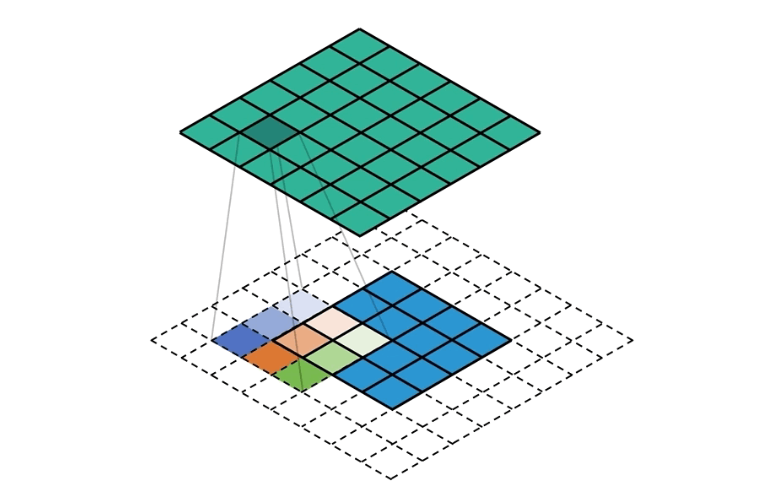

Сама архитектура сети выглядит примерно так:

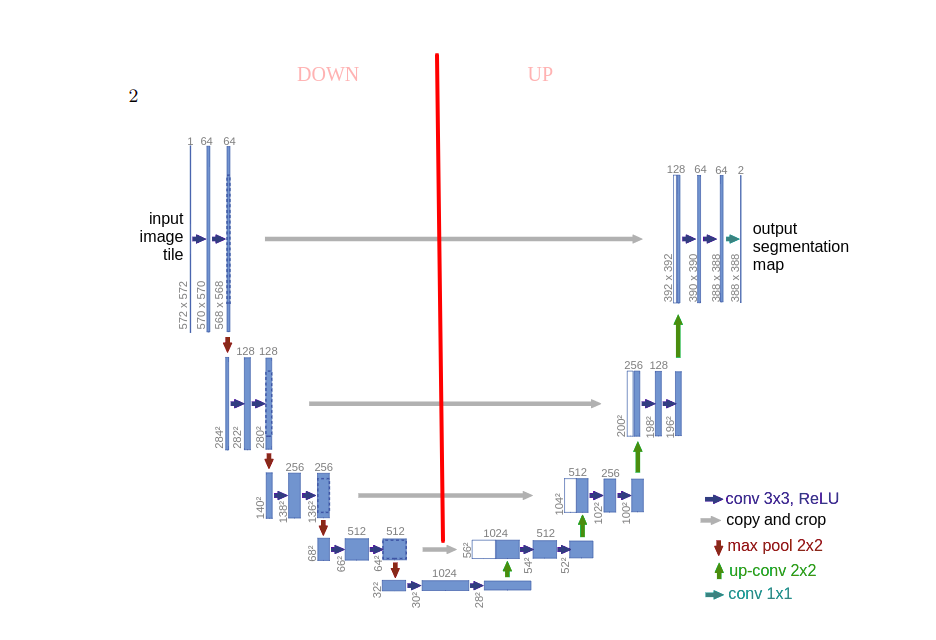

По мере прохождения по сети, изображение уменьшается в размере, но увеличивается количество слоев фич, которые используются. Потом, когда в самом низу остается только один пиксель, с помощью upsampling-а изображение вновь восстанавливается до изначального изображения.

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from cv2 import filter2D

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [2]:
TRAIN_DIR = "data/cells/train/"
MASK_DIR = "data/cells/mask/"

ids = next(os.walk(TRAIN_DIR))[2] # list of names all images in the given path
ids_m = next(os.walk(MASK_DIR))[2] # list of names all images in the given path

print("No. of images = ", len(ids))

No. of images =  5635


In [3]:
im_width = 256
im_height = 256

In [4]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

In [5]:
kernel_size = 3
kernel = -1 * np.ones((kernel_size, kernel_size))
kernel[kernel_size // 2 + 1, kernel_size// 2 + 1] = kernel_size ** 2 - 1

for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    try:
        img = load_img(TRAIN_DIR+id_, color_mode = "grayscale")
        x_img = img_to_array(img)
        x_img = resize(x_img, (im_width, im_height, 1), mode = 'constant', preserve_range = True)
        # Load masks
        mask = img_to_array(load_img(MASK_DIR + id_[:-4] + '_mask' '.tif', color_mode = "grayscale"))
        mask = filter2D(mask[...,0] , -1, kernel)
        mask = resize(mask, (im_width, im_height, 1), mode = 'constant', preserve_range = True)
        mask[mask!=0] = 1
        X[n] = x_img/255.0
        y[n] = mask/255.0
    except FileNotFoundError:
        X[n] = 0/255.0
        y[n] = 0/255.0
    
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

In [6]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [7]:
# def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
#     # contracting path
#     c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
#     p1 = MaxPooling2D((2, 2)) (c1)
#     p1 = Dropout(dropout*0.5)(p1)

#     c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
#     p2 = MaxPooling2D((2, 2)) (c2)
#     p2 = Dropout(dropout)(p2)

#     c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
#     p3 = MaxPooling2D((2, 2)) (c3)
#     p3 = Dropout(dropout)(p3)

#     c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
#     p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
#     p4 = Dropout(dropout)(p4)
    
#     c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
#     # expansive path
#     u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
#     u6 = concatenate([u6, c4])
#     u6 = Dropout(dropout)(u6)
#     c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

#     u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
#     u7 = concatenate([u7, c3])
#     u7 = Dropout(dropout)(u7)
#     c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

#     u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
#     u8 = concatenate([u8, c2])
#     u8 = Dropout(dropout)(u8)
#     c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

#     u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
#     u9 = concatenate([u9, c1], axis=3)
#     u9 = Dropout(dropout)(u9)
#     c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
#     outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
#     model = Model(inputs=[input_img], outputs=[outputs])
#     return model


def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    
    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)


    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c3)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [8]:
from keras.layers import Layer
import keras.backend as K

In [9]:
# def weighted_bce(y_true, y_pred):
#     weights = (y_true * 3.) + 1.
#     bce = K.binary_crossentropy(y_true, y_pred)
#     weighted_bce = K.mean(bce * weights)
#     return weighted_bce

In [10]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.01, batchnorm=True)

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=["accuracy"])
# model.compile(optimizer=Adam(), loss=weighted_bce, metrics=["accuracy"])

# model.summary()

In [11]:
callbacks = [
    EarlyStopping(patience=10, verbose=0),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=0),
    ModelCheckpoint('model_weighted_1.h5', verbose=1, save_best_only=True, save_weights_only=False)
]


In [13]:
results = model.fit(X_train, y_train, batch_size=5, epochs=7, callbacks=callbacks,
                    validation_data=(X_valid, y_valid), class_weight = 'auto')


Train on 5071 samples, validate on 564 samples
Epoch 1/7


 915/5071 [====>.........................] - ETA: 57:07 - loss: 0.6931 - accuracy: 0.508 - ETA: 32:52 - loss: 0.6701 - accuracy: 0.582 - ETA: 24:48 - loss: 0.6611 - accuracy: 0.594 - ETA: 20:44 - loss: 0.6469 - accuracy: 0.622 - ETA: 18:18 - loss: 0.6328 - accuracy: 0.656 - ETA: 16:40 - loss: 0.6271 - accuracy: 0.662 - ETA: 15:29 - loss: 0.6174 - accuracy: 0.681 - ETA: 14:36 - loss: 0.6050 - accuracy: 0.706 - ETA: 13:54 - loss: 0.5947 - accuracy: 0.731 - ETA: 13:21 - loss: 0.5836 - accuracy: 0.745 - ETA: 12:53 - loss: 0.5729 - accuracy: 0.759 - ETA: 12:32 - loss: 0.5630 - accuracy: 0.770 - ETA: 12:12 - loss: 0.5561 - accuracy: 0.780 - ETA: 11:56 - loss: 0.5502 - accuracy: 0.787 - ETA: 11:43 - loss: 0.5421 - accuracy: 0.799 - ETA: 11:31 - loss: 0.5330 - accuracy: 0.809 - ETA: 11:20 - loss: 0.5284 - accuracy: 0.815 - ETA: 11:10 - loss: 0.5199 - accuracy: 0.823 - ETA: 11:02 - loss: 0.5141 - accuracy: 0.829 - ETA: 10:55 - loss: 0.5060 - accuracy: 0.836 - ETA: 10:47 - loss: 0.5012 - accurac

1845/5071 [=========>....................] - ETA: 7:51 - loss: 0.1945 - accuracy: 0.97 - ETA: 7:51 - loss: 0.1938 - accuracy: 0.97 - ETA: 7:51 - loss: 0.1932 - accuracy: 0.97 - ETA: 7:50 - loss: 0.1925 - accuracy: 0.97 - ETA: 7:50 - loss: 0.1919 - accuracy: 0.97 - ETA: 7:50 - loss: 0.1913 - accuracy: 0.97 - ETA: 7:49 - loss: 0.1907 - accuracy: 0.97 - ETA: 7:49 - loss: 0.1901 - accuracy: 0.97 - ETA: 7:48 - loss: 0.1895 - accuracy: 0.97 - ETA: 7:48 - loss: 0.1888 - accuracy: 0.97 - ETA: 7:47 - loss: 0.1882 - accuracy: 0.97 - ETA: 7:47 - loss: 0.1877 - accuracy: 0.97 - ETA: 7:46 - loss: 0.1871 - accuracy: 0.97 - ETA: 7:46 - loss: 0.1865 - accuracy: 0.97 - ETA: 7:46 - loss: 0.1859 - accuracy: 0.97 - ETA: 7:46 - loss: 0.1854 - accuracy: 0.97 - ETA: 7:45 - loss: 0.1848 - accuracy: 0.97 - ETA: 7:45 - loss: 0.1842 - accuracy: 0.97 - ETA: 7:45 - loss: 0.1836 - accuracy: 0.97 - ETA: 7:44 - loss: 0.1831 - accuracy: 0.97 - ETA: 7:44 - loss: 0.1825 - accuracy: 0.97 - ETA: 7:45 - loss: 0.1819 - accu

2775/5071 [===============>..............] - ETA: 7:10 - loss: 0.1216 - accuracy: 0.98 - ETA: 7:09 - loss: 0.1213 - accuracy: 0.98 - ETA: 7:08 - loss: 0.1211 - accuracy: 0.98 - ETA: 7:08 - loss: 0.1208 - accuracy: 0.98 - ETA: 7:07 - loss: 0.1206 - accuracy: 0.98 - ETA: 7:07 - loss: 0.1203 - accuracy: 0.98 - ETA: 7:06 - loss: 0.1201 - accuracy: 0.98 - ETA: 7:05 - loss: 0.1198 - accuracy: 0.98 - ETA: 7:05 - loss: 0.1196 - accuracy: 0.98 - ETA: 7:05 - loss: 0.1194 - accuracy: 0.98 - ETA: 7:04 - loss: 0.1191 - accuracy: 0.98 - ETA: 7:04 - loss: 0.1189 - accuracy: 0.98 - ETA: 7:03 - loss: 0.1187 - accuracy: 0.98 - ETA: 7:03 - loss: 0.1184 - accuracy: 0.98 - ETA: 7:02 - loss: 0.1182 - accuracy: 0.98 - ETA: 7:02 - loss: 0.1179 - accuracy: 0.98 - ETA: 7:01 - loss: 0.1177 - accuracy: 0.98 - ETA: 7:00 - loss: 0.1175 - accuracy: 0.98 - ETA: 7:00 - loss: 0.1172 - accuracy: 0.98 - ETA: 6:59 - loss: 0.1172 - accuracy: 0.98 - ETA: 6:58 - loss: 0.1169 - accuracy: 0.98 - ETA: 6:58 - loss: 0.1167 - accu

3705/5071 [====================>.........] - ETA: 5:07 - loss: 0.0881 - accuracy: 0.98 - ETA: 5:07 - loss: 0.0879 - accuracy: 0.98 - ETA: 5:06 - loss: 0.0878 - accuracy: 0.98 - ETA: 5:05 - loss: 0.0877 - accuracy: 0.98 - ETA: 5:05 - loss: 0.0875 - accuracy: 0.98 - ETA: 5:04 - loss: 0.0874 - accuracy: 0.98 - ETA: 5:03 - loss: 0.0873 - accuracy: 0.98 - ETA: 5:03 - loss: 0.0871 - accuracy: 0.98 - ETA: 5:02 - loss: 0.0870 - accuracy: 0.98 - ETA: 5:01 - loss: 0.0869 - accuracy: 0.98 - ETA: 5:00 - loss: 0.0868 - accuracy: 0.98 - ETA: 5:00 - loss: 0.0866 - accuracy: 0.98 - ETA: 4:59 - loss: 0.0865 - accuracy: 0.98 - ETA: 4:58 - loss: 0.0864 - accuracy: 0.99 - ETA: 4:58 - loss: 0.0863 - accuracy: 0.99 - ETA: 4:57 - loss: 0.0861 - accuracy: 0.99 - ETA: 4:56 - loss: 0.0860 - accuracy: 0.99 - ETA: 4:56 - loss: 0.0859 - accuracy: 0.99 - ETA: 4:55 - loss: 0.0857 - accuracy: 0.99 - ETA: 4:54 - loss: 0.0856 - accuracy: 0.99 - ETA: 4:54 - loss: 0.0855 - accuracy: 0.99 - ETA: 4:53 - loss: 0.0854 - accu

4635/5071 [==========================>...] - ETA: 3:01 - loss: 0.0688 - accuracy: 0.99 - ETA: 3:01 - loss: 0.0687 - accuracy: 0.99 - ETA: 3:00 - loss: 0.0687 - accuracy: 0.99 - ETA: 2:59 - loss: 0.0686 - accuracy: 0.99 - ETA: 2:59 - loss: 0.0685 - accuracy: 0.99 - ETA: 2:58 - loss: 0.0684 - accuracy: 0.99 - ETA: 2:57 - loss: 0.0683 - accuracy: 0.99 - ETA: 2:57 - loss: 0.0683 - accuracy: 0.99 - ETA: 2:56 - loss: 0.0682 - accuracy: 0.99 - ETA: 2:55 - loss: 0.0681 - accuracy: 0.99 - ETA: 2:55 - loss: 0.0680 - accuracy: 0.99 - ETA: 2:54 - loss: 0.0679 - accuracy: 0.99 - ETA: 2:53 - loss: 0.0679 - accuracy: 0.99 - ETA: 2:53 - loss: 0.0678 - accuracy: 0.99 - ETA: 2:52 - loss: 0.0677 - accuracy: 0.99 - ETA: 2:51 - loss: 0.0676 - accuracy: 0.99 - ETA: 2:51 - loss: 0.0676 - accuracy: 0.99 - ETA: 2:50 - loss: 0.0675 - accuracy: 0.99 - ETA: 2:49 - loss: 0.0674 - accuracy: 0.99 - ETA: 2:49 - loss: 0.0673 - accuracy: 0.99 - ETA: 2:48 - loss: 0.0672 - accuracy: 0.99 - ETA: 2:47 - loss: 0.0672 - accu

5071/5071 [==============================] - ETA: 56s - loss: 0.0564 - accuracy: 0.992 - ETA: 56s - loss: 0.0564 - accuracy: 0.992 - ETA: 55s - loss: 0.0563 - accuracy: 0.992 - ETA: 54s - loss: 0.0563 - accuracy: 0.992 - ETA: 54s - loss: 0.0562 - accuracy: 0.992 - ETA: 53s - loss: 0.0562 - accuracy: 0.992 - ETA: 52s - loss: 0.0561 - accuracy: 0.992 - ETA: 52s - loss: 0.0561 - accuracy: 0.992 - ETA: 51s - loss: 0.0560 - accuracy: 0.992 - ETA: 50s - loss: 0.0560 - accuracy: 0.992 - ETA: 50s - loss: 0.0559 - accuracy: 0.992 - ETA: 49s - loss: 0.0558 - accuracy: 0.992 - ETA: 48s - loss: 0.0558 - accuracy: 0.992 - ETA: 48s - loss: 0.0557 - accuracy: 0.992 - ETA: 47s - loss: 0.0557 - accuracy: 0.992 - ETA: 46s - loss: 0.0556 - accuracy: 0.992 - ETA: 46s - loss: 0.0556 - accuracy: 0.992 - ETA: 45s - loss: 0.0555 - accuracy: 0.992 - ETA: 45s - loss: 0.0555 - accuracy: 0.992 - ETA: 44s - loss: 0.0554 - accuracy: 0.992 - ETA: 43s - loss: 0.0554 - accuracy: 0.992 - ETA: 43s - loss: 0.0553 - accur

 915/5071 [====>.........................] - ETA: 10:06 - loss: 0.0047 - accuracy: 0.995 - ETA: 10:11 - loss: 0.0047 - accuracy: 0.995 - ETA: 10:31 - loss: 0.0047 - accuracy: 0.996 - ETA: 10:28 - loss: 0.0047 - accuracy: 0.996 - ETA: 10:32 - loss: 0.0047 - accuracy: 0.997 - ETA: 10:34 - loss: 0.0047 - accuracy: 0.996 - ETA: 10:34 - loss: 0.0048 - accuracy: 0.996 - ETA: 10:34 - loss: 0.0048 - accuracy: 0.996 - ETA: 10:33 - loss: 0.0048 - accuracy: 0.996 - ETA: 10:36 - loss: 0.0048 - accuracy: 0.996 - ETA: 10:39 - loss: 0.0047 - accuracy: 0.997 - ETA: 10:38 - loss: 0.0047 - accuracy: 0.997 - ETA: 10:39 - loss: 0.0047 - accuracy: 0.996 - ETA: 10:37 - loss: 0.0047 - accuracy: 0.997 - ETA: 10:36 - loss: 0.0047 - accuracy: 0.997 - ETA: 10:35 - loss: 0.0047 - accuracy: 0.996 - ETA: 10:35 - loss: 0.0047 - accuracy: 0.996 - ETA: 10:36 - loss: 0.0047 - accuracy: 0.997 - ETA: 10:35 - loss: 0.0047 - accuracy: 0.996 - ETA: 10:34 - loss: 0.0047 - accuracy: 0.996 - ETA: 10:34 - loss: 0.0047 - accurac

1845/5071 [=========>....................] - ETA: 8:27 - loss: 0.0041 - accuracy: 0.99 - ETA: 8:26 - loss: 0.0041 - accuracy: 0.99 - ETA: 8:26 - loss: 0.0041 - accuracy: 0.99 - ETA: 8:25 - loss: 0.0040 - accuracy: 0.99 - ETA: 8:24 - loss: 0.0040 - accuracy: 0.99 - ETA: 8:23 - loss: 0.0040 - accuracy: 0.99 - ETA: 8:23 - loss: 0.0040 - accuracy: 0.99 - ETA: 8:22 - loss: 0.0040 - accuracy: 0.99 - ETA: 8:21 - loss: 0.0040 - accuracy: 0.99 - ETA: 8:20 - loss: 0.0040 - accuracy: 0.99 - ETA: 8:19 - loss: 0.0040 - accuracy: 0.99 - ETA: 8:19 - loss: 0.0040 - accuracy: 0.99 - ETA: 8:18 - loss: 0.0040 - accuracy: 0.99 - ETA: 8:17 - loss: 0.0040 - accuracy: 0.99 - ETA: 8:16 - loss: 0.0040 - accuracy: 0.99 - ETA: 8:15 - loss: 0.0040 - accuracy: 0.99 - ETA: 8:15 - loss: 0.0040 - accuracy: 0.99 - ETA: 8:14 - loss: 0.0040 - accuracy: 0.99 - ETA: 8:13 - loss: 0.0040 - accuracy: 0.99 - ETA: 8:12 - loss: 0.0040 - accuracy: 0.99 - ETA: 8:12 - loss: 0.0040 - accuracy: 0.99 - ETA: 8:11 - loss: 0.0040 - accu

2775/5071 [===============>..............] - ETA: 6:25 - loss: 0.0035 - accuracy: 0.99 - ETA: 6:25 - loss: 0.0035 - accuracy: 0.99 - ETA: 6:24 - loss: 0.0035 - accuracy: 0.99 - ETA: 6:24 - loss: 0.0035 - accuracy: 0.99 - ETA: 6:23 - loss: 0.0035 - accuracy: 0.99 - ETA: 6:23 - loss: 0.0035 - accuracy: 0.99 - ETA: 6:22 - loss: 0.0035 - accuracy: 0.99 - ETA: 6:21 - loss: 0.0035 - accuracy: 0.99 - ETA: 6:21 - loss: 0.0035 - accuracy: 0.99 - ETA: 6:20 - loss: 0.0035 - accuracy: 0.99 - ETA: 6:20 - loss: 0.0035 - accuracy: 0.99 - ETA: 6:19 - loss: 0.0035 - accuracy: 0.99 - ETA: 6:18 - loss: 0.0035 - accuracy: 0.99 - ETA: 6:18 - loss: 0.0035 - accuracy: 0.99 - ETA: 6:17 - loss: 0.0035 - accuracy: 0.99 - ETA: 6:16 - loss: 0.0035 - accuracy: 0.99 - ETA: 6:16 - loss: 0.0035 - accuracy: 0.99 - ETA: 6:15 - loss: 0.0035 - accuracy: 0.99 - ETA: 6:14 - loss: 0.0035 - accuracy: 0.99 - ETA: 6:14 - loss: 0.0035 - accuracy: 0.99 - ETA: 6:13 - loss: 0.0035 - accuracy: 0.99 - ETA: 6:12 - loss: 0.0035 - accu

3705/5071 [====================>.........] - ETA: 4:33 - loss: 0.0031 - accuracy: 0.99 - ETA: 4:32 - loss: 0.0031 - accuracy: 0.99 - ETA: 4:32 - loss: 0.0031 - accuracy: 0.99 - ETA: 4:31 - loss: 0.0031 - accuracy: 0.99 - ETA: 4:30 - loss: 0.0031 - accuracy: 0.99 - ETA: 4:30 - loss: 0.0031 - accuracy: 0.99 - ETA: 4:29 - loss: 0.0031 - accuracy: 0.99 - ETA: 4:29 - loss: 0.0031 - accuracy: 0.99 - ETA: 4:28 - loss: 0.0031 - accuracy: 0.99 - ETA: 4:27 - loss: 0.0031 - accuracy: 0.99 - ETA: 4:27 - loss: 0.0031 - accuracy: 0.99 - ETA: 4:26 - loss: 0.0031 - accuracy: 0.99 - ETA: 4:26 - loss: 0.0031 - accuracy: 0.99 - ETA: 4:25 - loss: 0.0031 - accuracy: 0.99 - ETA: 4:24 - loss: 0.0031 - accuracy: 0.99 - ETA: 4:24 - loss: 0.0031 - accuracy: 0.99 - ETA: 4:23 - loss: 0.0031 - accuracy: 0.99 - ETA: 4:23 - loss: 0.0031 - accuracy: 0.99 - ETA: 4:22 - loss: 0.0031 - accuracy: 0.99 - ETA: 4:21 - loss: 0.0031 - accuracy: 0.99 - ETA: 4:21 - loss: 0.0031 - accuracy: 0.99 - ETA: 4:20 - loss: 0.0031 - accu

4635/5071 [==========================>...] - ETA: 2:43 - loss: 0.0028 - accuracy: 0.99 - ETA: 2:42 - loss: 0.0028 - accuracy: 0.99 - ETA: 2:42 - loss: 0.0028 - accuracy: 0.99 - ETA: 2:41 - loss: 0.0028 - accuracy: 0.99 - ETA: 2:40 - loss: 0.0028 - accuracy: 0.99 - ETA: 2:40 - loss: 0.0028 - accuracy: 0.99 - ETA: 2:39 - loss: 0.0028 - accuracy: 0.99 - ETA: 2:39 - loss: 0.0028 - accuracy: 0.99 - ETA: 2:38 - loss: 0.0028 - accuracy: 0.99 - ETA: 2:38 - loss: 0.0028 - accuracy: 0.99 - ETA: 2:37 - loss: 0.0028 - accuracy: 0.99 - ETA: 2:36 - loss: 0.0028 - accuracy: 0.99 - ETA: 2:36 - loss: 0.0028 - accuracy: 0.99 - ETA: 2:35 - loss: 0.0028 - accuracy: 0.99 - ETA: 2:35 - loss: 0.0028 - accuracy: 0.99 - ETA: 2:34 - loss: 0.0028 - accuracy: 0.99 - ETA: 2:33 - loss: 0.0028 - accuracy: 0.99 - ETA: 2:33 - loss: 0.0028 - accuracy: 0.99 - ETA: 2:32 - loss: 0.0028 - accuracy: 0.99 - ETA: 2:32 - loss: 0.0028 - accuracy: 0.99 - ETA: 2:31 - loss: 0.0027 - accuracy: 0.99 - ETA: 2:30 - loss: 0.0027 - accu

5071/5071 [==============================] - ETA: 51s - loss: 0.0025 - accuracy: 0.995 - ETA: 51s - loss: 0.0025 - accuracy: 0.995 - ETA: 50s - loss: 0.0025 - accuracy: 0.995 - ETA: 49s - loss: 0.0025 - accuracy: 0.995 - ETA: 49s - loss: 0.0025 - accuracy: 0.995 - ETA: 48s - loss: 0.0025 - accuracy: 0.995 - ETA: 48s - loss: 0.0025 - accuracy: 0.995 - ETA: 47s - loss: 0.0025 - accuracy: 0.995 - ETA: 46s - loss: 0.0025 - accuracy: 0.995 - ETA: 46s - loss: 0.0025 - accuracy: 0.995 - ETA: 45s - loss: 0.0025 - accuracy: 0.995 - ETA: 45s - loss: 0.0025 - accuracy: 0.995 - ETA: 44s - loss: 0.0025 - accuracy: 0.995 - ETA: 43s - loss: 0.0025 - accuracy: 0.995 - ETA: 43s - loss: 0.0025 - accuracy: 0.995 - ETA: 42s - loss: 0.0025 - accuracy: 0.995 - ETA: 42s - loss: 0.0025 - accuracy: 0.995 - ETA: 41s - loss: 0.0025 - accuracy: 0.995 - ETA: 40s - loss: 0.0025 - accuracy: 0.995 - ETA: 40s - loss: 0.0025 - accuracy: 0.995 - ETA: 39s - loss: 0.0025 - accuracy: 0.995 - ETA: 39s - loss: 0.0025 - accur

 930/5071 [====>.........................] - ETA: 9:32 - loss: 0.0014 - accuracy: 0.98 - ETA: 9:34 - loss: 0.0012 - accuracy: 0.99 - ETA: 9:41 - loss: 0.0013 - accuracy: 0.99 - ETA: 9:39 - loss: 0.0012 - accuracy: 0.99 - ETA: 9:33 - loss: 0.0012 - accuracy: 0.99 - ETA: 9:31 - loss: 0.0012 - accuracy: 0.99 - ETA: 9:37 - loss: 0.0013 - accuracy: 0.99 - ETA: 9:32 - loss: 0.0012 - accuracy: 0.99 - ETA: 9:31 - loss: 0.0012 - accuracy: 0.99 - ETA: 9:30 - loss: 0.0012 - accuracy: 0.99 - ETA: 9:30 - loss: 0.0012 - accuracy: 0.99 - ETA: 9:29 - loss: 0.0012 - accuracy: 0.99 - ETA: 9:28 - loss: 0.0012 - accuracy: 0.99 - ETA: 9:27 - loss: 0.0012 - accuracy: 0.99 - ETA: 9:26 - loss: 0.0012 - accuracy: 0.99 - ETA: 9:25 - loss: 0.0012 - accuracy: 0.99 - ETA: 9:25 - loss: 0.0012 - accuracy: 0.99 - ETA: 9:25 - loss: 0.0012 - accuracy: 0.99 - ETA: 9:26 - loss: 0.0012 - accuracy: 0.99 - ETA: 9:26 - loss: 0.0012 - accuracy: 0.99 - ETA: 9:26 - loss: 0.0012 - accuracy: 0.99 - ETA: 9:28 - loss: 0.0012 - accu

1860/5071 [==========>...................] - ETA: 8:05 - loss: 0.0011 - accuracy: 0.99 - ETA: 8:05 - loss: 0.0011 - accuracy: 0.99 - ETA: 8:04 - loss: 0.0011 - accuracy: 0.99 - ETA: 8:04 - loss: 0.0011 - accuracy: 0.99 - ETA: 8:03 - loss: 0.0011 - accuracy: 0.99 - ETA: 8:03 - loss: 0.0011 - accuracy: 0.99 - ETA: 8:02 - loss: 0.0011 - accuracy: 0.99 - ETA: 8:02 - loss: 0.0011 - accuracy: 0.99 - ETA: 8:01 - loss: 0.0011 - accuracy: 0.99 - ETA: 8:00 - loss: 0.0011 - accuracy: 0.99 - ETA: 8:00 - loss: 0.0011 - accuracy: 0.99 - ETA: 7:59 - loss: 0.0011 - accuracy: 0.99 - ETA: 7:58 - loss: 0.0011 - accuracy: 0.99 - ETA: 7:58 - loss: 0.0011 - accuracy: 0.99 - ETA: 7:57 - loss: 0.0011 - accuracy: 0.99 - ETA: 7:57 - loss: 0.0011 - accuracy: 0.99 - ETA: 7:56 - loss: 0.0011 - accuracy: 0.99 - ETA: 7:55 - loss: 0.0011 - accuracy: 0.99 - ETA: 7:55 - loss: 0.0011 - accuracy: 0.99 - ETA: 7:54 - loss: 0.0011 - accuracy: 0.99 - ETA: 7:53 - loss: 0.0011 - accuracy: 0.99 - ETA: 7:53 - loss: 0.0011 - accu

2735/5071 [===============>..............] - ETA: 6:16 - loss: 0.0010 - accuracy: 0.99 - ETA: 6:16 - loss: 0.0010 - accuracy: 0.99 - ETA: 6:15 - loss: 0.0010 - accuracy: 0.99 - ETA: 6:15 - loss: 0.0010 - accuracy: 0.99 - ETA: 6:14 - loss: 0.0010 - accuracy: 0.99 - ETA: 6:14 - loss: 0.0010 - accuracy: 0.99 - ETA: 6:13 - loss: 0.0010 - accuracy: 0.99 - ETA: 6:13 - loss: 0.0010 - accuracy: 0.99 - ETA: 6:12 - loss: 0.0010 - accuracy: 0.99 - ETA: 6:12 - loss: 0.0010 - accuracy: 0.99 - ETA: 6:11 - loss: 0.0010 - accuracy: 0.99 - ETA: 6:11 - loss: 0.0010 - accuracy: 0.99 - ETA: 6:10 - loss: 0.0010 - accuracy: 0.99 - ETA: 6:10 - loss: 0.0010 - accuracy: 0.99 - ETA: 6:09 - loss: 0.0010 - accuracy: 0.99 - ETA: 6:09 - loss: 0.0010 - accuracy: 0.99 - ETA: 6:08 - loss: 0.0010 - accuracy: 0.99 - ETA: 6:08 - loss: 0.0010 - accuracy: 0.99 - ETA: 6:07 - loss: 0.0010 - accuracy: 0.99 - ETA: 6:07 - loss: 0.0010 - accuracy: 0.99 - ETA: 6:06 - loss: 0.0010 - accuracy: 0.99 - ETA: 6:06 - loss: 0.0010 - accu

3585/5071 [====================>.........] - ETA: 4:37 - loss: 9.5169e-04 - accuracy: 0.99 - ETA: 4:36 - loss: 9.5123e-04 - accuracy: 0.99 - ETA: 4:36 - loss: 9.5063e-04 - accuracy: 0.99 - ETA: 4:35 - loss: 9.5038e-04 - accuracy: 0.99 - ETA: 4:35 - loss: 9.5007e-04 - accuracy: 0.99 - ETA: 4:34 - loss: 9.4958e-04 - accuracy: 0.99 - ETA: 4:33 - loss: 9.4911e-04 - accuracy: 0.99 - ETA: 4:33 - loss: 9.4865e-04 - accuracy: 0.99 - ETA: 4:32 - loss: 9.4831e-04 - accuracy: 0.99 - ETA: 4:32 - loss: 9.4825e-04 - accuracy: 0.99 - ETA: 4:31 - loss: 9.4790e-04 - accuracy: 0.99 - ETA: 4:30 - loss: 9.4790e-04 - accuracy: 0.99 - ETA: 4:30 - loss: 9.4773e-04 - accuracy: 0.99 - ETA: 4:29 - loss: 9.4726e-04 - accuracy: 0.99 - ETA: 4:29 - loss: 9.4695e-04 - accuracy: 0.99 - ETA: 4:28 - loss: 9.4665e-04 - accuracy: 0.99 - ETA: 4:28 - loss: 9.4641e-04 - accuracy: 0.99 - ETA: 4:27 - loss: 9.4606e-04 - accuracy: 0.99 - ETA: 4:26 - loss: 9.4560e-04 - accuracy: 0.99 - ETA: 4:26 - loss: 9.4503e-04 - accuracy: 0.

4435/5071 [=========================>....] - ETA: 2:56 - loss: 8.9559e-04 - accuracy: 0.99 - ETA: 2:56 - loss: 8.9521e-04 - accuracy: 0.99 - ETA: 2:55 - loss: 8.9483e-04 - accuracy: 0.99 - ETA: 2:55 - loss: 8.9458e-04 - accuracy: 0.99 - ETA: 2:54 - loss: 8.9441e-04 - accuracy: 0.99 - ETA: 2:54 - loss: 8.9412e-04 - accuracy: 0.99 - ETA: 2:53 - loss: 8.9383e-04 - accuracy: 0.99 - ETA: 2:52 - loss: 8.9355e-04 - accuracy: 0.99 - ETA: 2:52 - loss: 8.9316e-04 - accuracy: 0.99 - ETA: 2:51 - loss: 8.9278e-04 - accuracy: 0.99 - ETA: 2:51 - loss: 8.9259e-04 - accuracy: 0.99 - ETA: 2:50 - loss: 8.9220e-04 - accuracy: 0.99 - ETA: 2:49 - loss: 8.9194e-04 - accuracy: 0.99 - ETA: 2:49 - loss: 8.9156e-04 - accuracy: 0.99 - ETA: 2:48 - loss: 8.9133e-04 - accuracy: 0.99 - ETA: 2:48 - loss: 8.9083e-04 - accuracy: 0.99 - ETA: 2:47 - loss: 8.9034e-04 - accuracy: 0.99 - ETA: 2:47 - loss: 8.8998e-04 - accuracy: 0.99 - ETA: 2:46 - loss: 8.8978e-04 - accuracy: 0.99 - ETA: 2:45 - loss: 8.8957e-04 - accuracy: 0.

5071/5071 [==============================] - ETA: 1:16 - loss: 8.4316e-04 - accuracy: 0.99 - ETA: 1:15 - loss: 8.4293e-04 - accuracy: 0.99 - ETA: 1:14 - loss: 8.4286e-04 - accuracy: 0.99 - ETA: 1:14 - loss: 8.4261e-04 - accuracy: 0.99 - ETA: 1:13 - loss: 8.4218e-04 - accuracy: 0.99 - ETA: 1:13 - loss: 8.4183e-04 - accuracy: 0.99 - ETA: 1:12 - loss: 8.4152e-04 - accuracy: 0.99 - ETA: 1:11 - loss: 8.4124e-04 - accuracy: 0.99 - ETA: 1:11 - loss: 8.4083e-04 - accuracy: 0.99 - ETA: 1:10 - loss: 8.4052e-04 - accuracy: 0.99 - ETA: 1:10 - loss: 8.4026e-04 - accuracy: 0.99 - ETA: 1:09 - loss: 8.3993e-04 - accuracy: 0.99 - ETA: 1:08 - loss: 8.3959e-04 - accuracy: 0.99 - ETA: 1:08 - loss: 8.3934e-04 - accuracy: 0.99 - ETA: 1:07 - loss: 8.3927e-04 - accuracy: 0.99 - ETA: 1:07 - loss: 8.3901e-04 - accuracy: 0.99 - ETA: 1:06 - loss: 8.3876e-04 - accuracy: 0.99 - ETA: 1:05 - loss: 8.3843e-04 - accuracy: 0.99 - ETA: 1:05 - loss: 8.3809e-04 - accuracy: 0.99 - ETA: 1:04 - loss: 8.3777e-04 - accuracy: 0.

 840/5071 [===>..........................] - ETA: 10:23 - loss: 5.3829e-04 - accuracy: 0.996 - ETA: 10:58 - loss: 4.7685e-04 - accuracy: 0.998 - ETA: 11:08 - loss: 5.1344e-04 - accuracy: 0.996 - ETA: 11:01 - loss: 5.4823e-04 - accuracy: 0.995 - ETA: 11:00 - loss: 5.3510e-04 - accuracy: 0.996 - ETA: 10:54 - loss: 5.3971e-04 - accuracy: 0.996 - ETA: 10:53 - loss: 5.2257e-04 - accuracy: 0.996 - ETA: 10:50 - loss: 5.3739e-04 - accuracy: 0.996 - ETA: 10:49 - loss: 5.3189e-04 - accuracy: 0.996 - ETA: 10:48 - loss: 5.3827e-04 - accuracy: 0.996 - ETA: 10:46 - loss: 5.3226e-04 - accuracy: 0.996 - ETA: 10:46 - loss: 5.3664e-04 - accuracy: 0.996 - ETA: 10:48 - loss: 5.2748e-04 - accuracy: 0.996 - ETA: 10:46 - loss: 5.4000e-04 - accuracy: 0.996 - ETA: 10:44 - loss: 5.3171e-04 - accuracy: 0.996 - ETA: 10:45 - loss: 5.3384e-04 - accuracy: 0.996 - ETA: 10:42 - loss: 5.3879e-04 - accuracy: 0.996 - ETA: 10:42 - loss: 5.4426e-04 - accuracy: 0.995 - ETA: 10:40 - loss: 5.4076e-04 - accuracy: 0.995 - ETA: 

1690/5071 [========>.....................] - ETA: 8:36 - loss: 5.2412e-04 - accuracy: 0.99 - ETA: 8:36 - loss: 5.2397e-04 - accuracy: 0.99 - ETA: 8:35 - loss: 5.2348e-04 - accuracy: 0.99 - ETA: 8:35 - loss: 5.2339e-04 - accuracy: 0.99 - ETA: 8:35 - loss: 5.2293e-04 - accuracy: 0.99 - ETA: 8:34 - loss: 5.2323e-04 - accuracy: 0.99 - ETA: 8:34 - loss: 5.2327e-04 - accuracy: 0.99 - ETA: 8:33 - loss: 5.2352e-04 - accuracy: 0.99 - ETA: 8:33 - loss: 5.2440e-04 - accuracy: 0.99 - ETA: 8:32 - loss: 5.2433e-04 - accuracy: 0.99 - ETA: 8:32 - loss: 5.2509e-04 - accuracy: 0.99 - ETA: 8:32 - loss: 5.2498e-04 - accuracy: 0.99 - ETA: 8:31 - loss: 5.2449e-04 - accuracy: 0.99 - ETA: 8:31 - loss: 5.2405e-04 - accuracy: 0.99 - ETA: 8:30 - loss: 5.2428e-04 - accuracy: 0.99 - ETA: 8:30 - loss: 5.2411e-04 - accuracy: 0.99 - ETA: 8:29 - loss: 5.2404e-04 - accuracy: 0.99 - ETA: 8:29 - loss: 5.2361e-04 - accuracy: 0.99 - ETA: 8:28 - loss: 5.2446e-04 - accuracy: 0.99 - ETA: 8:28 - loss: 5.2391e-04 - accuracy: 0.

2540/5071 [==============>...............] - ETA: 6:53 - loss: 4.9877e-04 - accuracy: 0.99 - ETA: 6:53 - loss: 4.9881e-04 - accuracy: 0.99 - ETA: 6:52 - loss: 4.9890e-04 - accuracy: 0.99 - ETA: 6:52 - loss: 4.9888e-04 - accuracy: 0.99 - ETA: 6:51 - loss: 4.9836e-04 - accuracy: 0.99 - ETA: 6:51 - loss: 4.9803e-04 - accuracy: 0.99 - ETA: 6:50 - loss: 4.9773e-04 - accuracy: 0.99 - ETA: 6:50 - loss: 4.9795e-04 - accuracy: 0.99 - ETA: 6:49 - loss: 4.9806e-04 - accuracy: 0.99 - ETA: 6:49 - loss: 4.9801e-04 - accuracy: 0.99 - ETA: 6:48 - loss: 4.9838e-04 - accuracy: 0.99 - ETA: 6:48 - loss: 4.9812e-04 - accuracy: 0.99 - ETA: 6:47 - loss: 4.9815e-04 - accuracy: 0.99 - ETA: 6:47 - loss: 4.9813e-04 - accuracy: 0.99 - ETA: 6:46 - loss: 4.9850e-04 - accuracy: 0.99 - ETA: 6:45 - loss: 4.9818e-04 - accuracy: 0.99 - ETA: 6:45 - loss: 4.9811e-04 - accuracy: 0.99 - ETA: 6:44 - loss: 4.9803e-04 - accuracy: 0.99 - ETA: 6:44 - loss: 4.9774e-04 - accuracy: 0.99 - ETA: 6:43 - loss: 4.9722e-04 - accuracy: 0.

3390/5071 [===================>..........] - ETA: 5:11 - loss: 4.7756e-04 - accuracy: 0.99 - ETA: 5:11 - loss: 4.7746e-04 - accuracy: 0.99 - ETA: 5:10 - loss: 4.7722e-04 - accuracy: 0.99 - ETA: 5:10 - loss: 4.7698e-04 - accuracy: 0.99 - ETA: 5:09 - loss: 4.7691e-04 - accuracy: 0.99 - ETA: 5:08 - loss: 4.7700e-04 - accuracy: 0.99 - ETA: 5:08 - loss: 4.7690e-04 - accuracy: 0.99 - ETA: 5:07 - loss: 4.7676e-04 - accuracy: 0.99 - ETA: 5:06 - loss: 4.7655e-04 - accuracy: 0.99 - ETA: 5:06 - loss: 4.7660e-04 - accuracy: 0.99 - ETA: 5:05 - loss: 4.7655e-04 - accuracy: 0.99 - ETA: 5:04 - loss: 4.7633e-04 - accuracy: 0.99 - ETA: 5:04 - loss: 4.7613e-04 - accuracy: 0.99 - ETA: 5:03 - loss: 4.7606e-04 - accuracy: 0.99 - ETA: 5:03 - loss: 4.7595e-04 - accuracy: 0.99 - ETA: 5:02 - loss: 4.7559e-04 - accuracy: 0.99 - ETA: 5:02 - loss: 4.7538e-04 - accuracy: 0.99 - ETA: 5:01 - loss: 4.7519e-04 - accuracy: 0.99 - ETA: 5:00 - loss: 4.7510e-04 - accuracy: 0.99 - ETA: 5:00 - loss: 4.7487e-04 - accuracy: 0.

4240/5071 [========================>.....] - ETA: 3:26 - loss: 4.5829e-04 - accuracy: 0.99 - ETA: 3:26 - loss: 4.5810e-04 - accuracy: 0.99 - ETA: 3:25 - loss: 4.5817e-04 - accuracy: 0.99 - ETA: 3:25 - loss: 4.5822e-04 - accuracy: 0.99 - ETA: 3:24 - loss: 4.5801e-04 - accuracy: 0.99 - ETA: 3:23 - loss: 4.5808e-04 - accuracy: 0.99 - ETA: 3:23 - loss: 4.5777e-04 - accuracy: 0.99 - ETA: 3:22 - loss: 4.5760e-04 - accuracy: 0.99 - ETA: 3:22 - loss: 4.5744e-04 - accuracy: 0.99 - ETA: 3:21 - loss: 4.5748e-04 - accuracy: 0.99 - ETA: 3:20 - loss: 4.5742e-04 - accuracy: 0.99 - ETA: 3:20 - loss: 4.5721e-04 - accuracy: 0.99 - ETA: 3:19 - loss: 4.5706e-04 - accuracy: 0.99 - ETA: 3:18 - loss: 4.5687e-04 - accuracy: 0.99 - ETA: 3:18 - loss: 4.5684e-04 - accuracy: 0.99 - ETA: 3:17 - loss: 4.5678e-04 - accuracy: 0.99 - ETA: 3:16 - loss: 4.5678e-04 - accuracy: 0.99 - ETA: 3:16 - loss: 4.5658e-04 - accuracy: 0.99 - ETA: 3:15 - loss: 4.5628e-04 - accuracy: 0.99 - ETA: 3:15 - loss: 4.5634e-04 - accuracy: 0.

5071/5071 [==============================] - ETA: 1:41 - loss: 4.3748e-04 - accuracy: 0.99 - ETA: 1:40 - loss: 4.3741e-04 - accuracy: 0.99 - ETA: 1:40 - loss: 4.3741e-04 - accuracy: 0.99 - ETA: 1:39 - loss: 4.3725e-04 - accuracy: 0.99 - ETA: 1:38 - loss: 4.3730e-04 - accuracy: 0.99 - ETA: 1:38 - loss: 4.3725e-04 - accuracy: 0.99 - ETA: 1:37 - loss: 4.3721e-04 - accuracy: 0.99 - ETA: 1:36 - loss: 4.3704e-04 - accuracy: 0.99 - ETA: 1:36 - loss: 4.3689e-04 - accuracy: 0.99 - ETA: 1:35 - loss: 4.3664e-04 - accuracy: 0.99 - ETA: 1:35 - loss: 4.3638e-04 - accuracy: 0.99 - ETA: 1:34 - loss: 4.3613e-04 - accuracy: 0.99 - ETA: 1:33 - loss: 4.3596e-04 - accuracy: 0.99 - ETA: 1:33 - loss: 4.3599e-04 - accuracy: 0.99 - ETA: 1:32 - loss: 4.3584e-04 - accuracy: 0.99 - ETA: 1:32 - loss: 4.3569e-04 - accuracy: 0.99 - ETA: 1:31 - loss: 4.3582e-04 - accuracy: 0.99 - ETA: 1:30 - loss: 4.3566e-04 - accuracy: 0.99 - ETA: 1:30 - loss: 4.3558e-04 - accuracy: 0.99 - ETA: 1:29 - loss: 4.3556e-04 - accuracy: 0.

 840/5071 [===>..........................] - ETA: 9:05 - loss: 3.5758e-04 - accuracy: 0.99 - ETA: 9:42 - loss: 3.3302e-04 - accuracy: 0.99 - ETA: 9:56 - loss: 3.4777e-04 - accuracy: 0.99 - ETA: 9:54 - loss: 3.7188e-04 - accuracy: 0.99 - ETA: 10:01 - loss: 3.5556e-04 - accuracy: 0.995 - ETA: 10:05 - loss: 3.5673e-04 - accuracy: 0.995 - ETA: 10:10 - loss: 3.4507e-04 - accuracy: 0.995 - ETA: 10:12 - loss: 3.4507e-04 - accuracy: 0.995 - ETA: 10:15 - loss: 3.2858e-04 - accuracy: 0.996 - ETA: 10:17 - loss: 3.3214e-04 - accuracy: 0.995 - ETA: 10:18 - loss: 3.3455e-04 - accuracy: 0.995 - ETA: 10:24 - loss: 3.4625e-04 - accuracy: 0.995 - ETA: 10:24 - loss: 3.4580e-04 - accuracy: 0.995 - ETA: 10:39 - loss: 3.4814e-04 - accuracy: 0.995 - ETA: 10:39 - loss: 3.4356e-04 - accuracy: 0.995 - ETA: 10:38 - loss: 3.4498e-04 - accuracy: 0.995 - ETA: 10:39 - loss: 3.5180e-04 - accuracy: 0.995 - ETA: 10:39 - loss: 3.5856e-04 - accuracy: 0.995 - ETA: 10:39 - loss: 3.5446e-04 - accuracy: 0.995 - ETA: 10:37 - 

1690/5071 [========>.....................] - ETA: 8:31 - loss: 3.1285e-04 - accuracy: 0.99 - ETA: 8:30 - loss: 3.1265e-04 - accuracy: 0.99 - ETA: 8:30 - loss: 3.1286e-04 - accuracy: 0.99 - ETA: 8:29 - loss: 3.1307e-04 - accuracy: 0.99 - ETA: 8:29 - loss: 3.1284e-04 - accuracy: 0.99 - ETA: 8:28 - loss: 3.1303e-04 - accuracy: 0.99 - ETA: 8:27 - loss: 3.1317e-04 - accuracy: 0.99 - ETA: 8:27 - loss: 3.1338e-04 - accuracy: 0.99 - ETA: 8:26 - loss: 3.1270e-04 - accuracy: 0.99 - ETA: 8:25 - loss: 3.1316e-04 - accuracy: 0.99 - ETA: 8:24 - loss: 3.1320e-04 - accuracy: 0.99 - ETA: 8:24 - loss: 3.1242e-04 - accuracy: 0.99 - ETA: 8:23 - loss: 3.1211e-04 - accuracy: 0.99 - ETA: 8:22 - loss: 3.1219e-04 - accuracy: 0.99 - ETA: 8:21 - loss: 3.1265e-04 - accuracy: 0.99 - ETA: 8:21 - loss: 3.1278e-04 - accuracy: 0.99 - ETA: 8:20 - loss: 3.1300e-04 - accuracy: 0.99 - ETA: 8:19 - loss: 3.1271e-04 - accuracy: 0.99 - ETA: 8:18 - loss: 3.1230e-04 - accuracy: 0.99 - ETA: 8:17 - loss: 3.1209e-04 - accuracy: 0.

2540/5071 [==============>...............] - ETA: 6:49 - loss: 3.0994e-04 - accuracy: 0.99 - ETA: 6:48 - loss: 3.0949e-04 - accuracy: 0.99 - ETA: 6:47 - loss: 3.0926e-04 - accuracy: 0.99 - ETA: 6:47 - loss: 3.0988e-04 - accuracy: 0.99 - ETA: 6:46 - loss: 3.0969e-04 - accuracy: 0.99 - ETA: 6:45 - loss: 3.0971e-04 - accuracy: 0.99 - ETA: 6:45 - loss: 3.0952e-04 - accuracy: 0.99 - ETA: 6:44 - loss: 3.0978e-04 - accuracy: 0.99 - ETA: 6:44 - loss: 3.0959e-04 - accuracy: 0.99 - ETA: 6:43 - loss: 3.0988e-04 - accuracy: 0.99 - ETA: 6:43 - loss: 3.0970e-04 - accuracy: 0.99 - ETA: 6:42 - loss: 3.0968e-04 - accuracy: 0.99 - ETA: 6:42 - loss: 3.0948e-04 - accuracy: 0.99 - ETA: 6:41 - loss: 3.0964e-04 - accuracy: 0.99 - ETA: 6:40 - loss: 3.0941e-04 - accuracy: 0.99 - ETA: 6:40 - loss: 3.0971e-04 - accuracy: 0.99 - ETA: 6:39 - loss: 3.0975e-04 - accuracy: 0.99 - ETA: 6:39 - loss: 3.1000e-04 - accuracy: 0.99 - ETA: 6:38 - loss: 3.0959e-04 - accuracy: 0.99 - ETA: 6:38 - loss: 3.0939e-04 - accuracy: 0.

3390/5071 [===================>..........] - ETA: 5:06 - loss: 3.0374e-04 - accuracy: 0.99 - ETA: 5:05 - loss: 3.0357e-04 - accuracy: 0.99 - ETA: 5:05 - loss: 3.0341e-04 - accuracy: 0.99 - ETA: 5:04 - loss: 3.0336e-04 - accuracy: 0.99 - ETA: 5:04 - loss: 3.0321e-04 - accuracy: 0.99 - ETA: 5:03 - loss: 3.0305e-04 - accuracy: 0.99 - ETA: 5:02 - loss: 3.0289e-04 - accuracy: 0.99 - ETA: 5:02 - loss: 3.0275e-04 - accuracy: 0.99 - ETA: 5:01 - loss: 3.0289e-04 - accuracy: 0.99 - ETA: 5:01 - loss: 3.0303e-04 - accuracy: 0.99 - ETA: 5:00 - loss: 3.0288e-04 - accuracy: 0.99 - ETA: 4:59 - loss: 3.0257e-04 - accuracy: 0.99 - ETA: 4:59 - loss: 3.0239e-04 - accuracy: 0.99 - ETA: 4:58 - loss: 3.0220e-04 - accuracy: 0.99 - ETA: 4:57 - loss: 3.0206e-04 - accuracy: 0.99 - ETA: 4:57 - loss: 3.0204e-04 - accuracy: 0.99 - ETA: 4:56 - loss: 3.0204e-04 - accuracy: 0.99 - ETA: 4:55 - loss: 3.0208e-04 - accuracy: 0.99 - ETA: 4:55 - loss: 3.0194e-04 - accuracy: 0.99 - ETA: 4:54 - loss: 3.0176e-04 - accuracy: 0.

4240/5071 [========================>.....] - ETA: 3:22 - loss: 2.9697e-04 - accuracy: 0.99 - ETA: 3:21 - loss: 2.9683e-04 - accuracy: 0.99 - ETA: 3:20 - loss: 2.9672e-04 - accuracy: 0.99 - ETA: 3:20 - loss: 2.9675e-04 - accuracy: 0.99 - ETA: 3:19 - loss: 2.9662e-04 - accuracy: 0.99 - ETA: 3:19 - loss: 2.9637e-04 - accuracy: 0.99 - ETA: 3:18 - loss: 2.9636e-04 - accuracy: 0.99 - ETA: 3:17 - loss: 2.9611e-04 - accuracy: 0.99 - ETA: 3:17 - loss: 2.9587e-04 - accuracy: 0.99 - ETA: 3:16 - loss: 2.9587e-04 - accuracy: 0.99 - ETA: 3:16 - loss: 2.9591e-04 - accuracy: 0.99 - ETA: 3:15 - loss: 2.9586e-04 - accuracy: 0.99 - ETA: 3:14 - loss: 2.9593e-04 - accuracy: 0.99 - ETA: 3:14 - loss: 2.9605e-04 - accuracy: 0.99 - ETA: 3:13 - loss: 2.9600e-04 - accuracy: 0.99 - ETA: 3:13 - loss: 2.9577e-04 - accuracy: 0.99 - ETA: 3:12 - loss: 2.9577e-04 - accuracy: 0.99 - ETA: 3:11 - loss: 2.9565e-04 - accuracy: 0.99 - ETA: 3:11 - loss: 2.9566e-04 - accuracy: 0.99 - ETA: 3:10 - loss: 2.9542e-04 - accuracy: 0.

5071/5071 [==============================] - ETA: 1:39 - loss: 2.9114e-04 - accuracy: 0.99 - ETA: 1:38 - loss: 2.9117e-04 - accuracy: 0.99 - ETA: 1:38 - loss: 2.9105e-04 - accuracy: 0.99 - ETA: 1:37 - loss: 2.9101e-04 - accuracy: 0.99 - ETA: 1:36 - loss: 2.9100e-04 - accuracy: 0.99 - ETA: 1:36 - loss: 2.9101e-04 - accuracy: 0.99 - ETA: 1:35 - loss: 2.9091e-04 - accuracy: 0.99 - ETA: 1:35 - loss: 2.9084e-04 - accuracy: 0.99 - ETA: 1:34 - loss: 2.9085e-04 - accuracy: 0.99 - ETA: 1:33 - loss: 2.9107e-04 - accuracy: 0.99 - ETA: 1:33 - loss: 2.9086e-04 - accuracy: 0.99 - ETA: 1:32 - loss: 2.9081e-04 - accuracy: 0.99 - ETA: 1:32 - loss: 2.9070e-04 - accuracy: 0.99 - ETA: 1:31 - loss: 2.9074e-04 - accuracy: 0.99 - ETA: 1:30 - loss: 2.9083e-04 - accuracy: 0.99 - ETA: 1:30 - loss: 2.9071e-04 - accuracy: 0.99 - ETA: 1:29 - loss: 2.9069e-04 - accuracy: 0.99 - ETA: 1:29 - loss: 2.9074e-04 - accuracy: 0.99 - ETA: 1:28 - loss: 2.9075e-04 - accuracy: 0.99 - ETA: 1:27 - loss: 2.9074e-04 - accuracy: 0.

 850/5071 [====>.........................] - ETA: 9:39 - loss: 3.3388e-04 - accuracy: 0.99 - ETA: 10:10 - loss: 2.1877e-04 - accuracy: 0.996 - ETA: 10:16 - loss: 2.4173e-04 - accuracy: 0.996 - ETA: 10:12 - loss: 2.2920e-04 - accuracy: 0.996 - ETA: 10:11 - loss: 2.0413e-04 - accuracy: 0.997 - ETA: 10:07 - loss: 1.9995e-04 - accuracy: 0.997 - ETA: 10:03 - loss: 2.3867e-04 - accuracy: 0.996 - ETA: 9:57 - loss: 2.2169e-04 - accuracy: 0.996 - ETA: 9:52 - loss: 2.2798e-04 - accuracy: 0.99 - ETA: 9:49 - loss: 2.3335e-04 - accuracy: 0.99 - ETA: 9:49 - loss: 2.4616e-04 - accuracy: 0.99 - ETA: 9:49 - loss: 2.4975e-04 - accuracy: 0.99 - ETA: 9:47 - loss: 2.3846e-04 - accuracy: 0.99 - ETA: 9:46 - loss: 2.4961e-04 - accuracy: 0.99 - ETA: 9:44 - loss: 2.4590e-04 - accuracy: 0.99 - ETA: 9:42 - loss: 2.3697e-04 - accuracy: 0.99 - ETA: 9:42 - loss: 2.3382e-04 - accuracy: 0.99 - ETA: 9:42 - loss: 2.3188e-04 - accuracy: 0.99 - ETA: 9:42 - loss: 2.2510e-04 - accuracy: 0.99 - ETA: 9:42 - loss: 2.2271e-04 -

1700/5071 [=========>....................] - ETA: 8:35 - loss: 2.4513e-04 - accuracy: 0.99 - ETA: 8:35 - loss: 2.4467e-04 - accuracy: 0.99 - ETA: 8:34 - loss: 2.4479e-04 - accuracy: 0.99 - ETA: 8:34 - loss: 2.4555e-04 - accuracy: 0.99 - ETA: 8:33 - loss: 2.4530e-04 - accuracy: 0.99 - ETA: 8:33 - loss: 2.4490e-04 - accuracy: 0.99 - ETA: 8:32 - loss: 2.4404e-04 - accuracy: 0.99 - ETA: 8:32 - loss: 2.4423e-04 - accuracy: 0.99 - ETA: 8:32 - loss: 2.4445e-04 - accuracy: 0.99 - ETA: 8:31 - loss: 2.4402e-04 - accuracy: 0.99 - ETA: 8:31 - loss: 2.4414e-04 - accuracy: 0.99 - ETA: 8:30 - loss: 2.4499e-04 - accuracy: 0.99 - ETA: 8:30 - loss: 2.4516e-04 - accuracy: 0.99 - ETA: 8:29 - loss: 2.4526e-04 - accuracy: 0.99 - ETA: 8:29 - loss: 2.4528e-04 - accuracy: 0.99 - ETA: 8:28 - loss: 2.4544e-04 - accuracy: 0.99 - ETA: 8:28 - loss: 2.4514e-04 - accuracy: 0.99 - ETA: 8:27 - loss: 2.4576e-04 - accuracy: 0.99 - ETA: 8:27 - loss: 2.4556e-04 - accuracy: 0.99 - ETA: 8:26 - loss: 2.4475e-04 - accuracy: 0.

2550/5071 [==============>...............] - ETA: 6:48 - loss: 2.4148e-04 - accuracy: 0.99 - ETA: 6:48 - loss: 2.4133e-04 - accuracy: 0.99 - ETA: 6:47 - loss: 2.4139e-04 - accuracy: 0.99 - ETA: 6:47 - loss: 2.4120e-04 - accuracy: 0.99 - ETA: 6:46 - loss: 2.4156e-04 - accuracy: 0.99 - ETA: 6:45 - loss: 2.4182e-04 - accuracy: 0.99 - ETA: 6:45 - loss: 2.4165e-04 - accuracy: 0.99 - ETA: 6:44 - loss: 2.4120e-04 - accuracy: 0.99 - ETA: 6:44 - loss: 2.4128e-04 - accuracy: 0.99 - ETA: 6:43 - loss: 2.4118e-04 - accuracy: 0.99 - ETA: 6:42 - loss: 2.4100e-04 - accuracy: 0.99 - ETA: 6:41 - loss: 2.4145e-04 - accuracy: 0.99 - ETA: 6:41 - loss: 2.4163e-04 - accuracy: 0.99 - ETA: 6:40 - loss: 2.4174e-04 - accuracy: 0.99 - ETA: 6:39 - loss: 2.4216e-04 - accuracy: 0.99 - ETA: 6:39 - loss: 2.4217e-04 - accuracy: 0.99 - ETA: 6:38 - loss: 2.4194e-04 - accuracy: 0.99 - ETA: 6:37 - loss: 2.4150e-04 - accuracy: 0.99 - ETA: 6:37 - loss: 2.4134e-04 - accuracy: 0.99 - ETA: 6:36 - loss: 2.4162e-04 - accuracy: 0.

3400/5071 [===================>..........] - ETA: 5:04 - loss: 2.3820e-04 - accuracy: 0.99 - ETA: 5:04 - loss: 2.3820e-04 - accuracy: 0.99 - ETA: 5:03 - loss: 2.3804e-04 - accuracy: 0.99 - ETA: 5:02 - loss: 2.3825e-04 - accuracy: 0.99 - ETA: 5:02 - loss: 2.3814e-04 - accuracy: 0.99 - ETA: 5:01 - loss: 2.3797e-04 - accuracy: 0.99 - ETA: 5:01 - loss: 2.3766e-04 - accuracy: 0.99 - ETA: 5:00 - loss: 2.3787e-04 - accuracy: 0.99 - ETA: 5:00 - loss: 2.3772e-04 - accuracy: 0.99 - ETA: 4:59 - loss: 2.3815e-04 - accuracy: 0.99 - ETA: 4:58 - loss: 2.3842e-04 - accuracy: 0.99 - ETA: 4:58 - loss: 2.3827e-04 - accuracy: 0.99 - ETA: 4:57 - loss: 2.3827e-04 - accuracy: 0.99 - ETA: 4:57 - loss: 2.3869e-04 - accuracy: 0.99 - ETA: 4:56 - loss: 2.3839e-04 - accuracy: 0.99 - ETA: 4:56 - loss: 2.3823e-04 - accuracy: 0.99 - ETA: 4:55 - loss: 2.3808e-04 - accuracy: 0.99 - ETA: 4:55 - loss: 2.3778e-04 - accuracy: 0.99 - ETA: 4:54 - loss: 2.3781e-04 - accuracy: 0.99 - ETA: 4:53 - loss: 2.3751e-04 - accuracy: 0.

4250/5071 [========================>.....] - ETA: 3:21 - loss: 2.3442e-04 - accuracy: 0.99 - ETA: 3:20 - loss: 2.3430e-04 - accuracy: 0.99 - ETA: 3:20 - loss: 2.3457e-04 - accuracy: 0.99 - ETA: 3:19 - loss: 2.3448e-04 - accuracy: 0.99 - ETA: 3:19 - loss: 2.3452e-04 - accuracy: 0.99 - ETA: 3:18 - loss: 2.3458e-04 - accuracy: 0.99 - ETA: 3:17 - loss: 2.3447e-04 - accuracy: 0.99 - ETA: 3:17 - loss: 2.3436e-04 - accuracy: 0.99 - ETA: 3:16 - loss: 2.3424e-04 - accuracy: 0.99 - ETA: 3:16 - loss: 2.3431e-04 - accuracy: 0.99 - ETA: 3:15 - loss: 2.3407e-04 - accuracy: 0.99 - ETA: 3:14 - loss: 2.3408e-04 - accuracy: 0.99 - ETA: 3:14 - loss: 2.3385e-04 - accuracy: 0.99 - ETA: 3:13 - loss: 2.3392e-04 - accuracy: 0.99 - ETA: 3:13 - loss: 2.3406e-04 - accuracy: 0.99 - ETA: 3:12 - loss: 2.3396e-04 - accuracy: 0.99 - ETA: 3:11 - loss: 2.3386e-04 - accuracy: 0.99 - ETA: 3:11 - loss: 2.3376e-04 - accuracy: 0.99 - ETA: 3:10 - loss: 2.3364e-04 - accuracy: 0.99 - ETA: 3:10 - loss: 2.3370e-04 - accuracy: 0.

5071/5071 [==============================] - ETA: 1:39 - loss: 2.2807e-04 - accuracy: 0.99 - ETA: 1:38 - loss: 2.2797e-04 - accuracy: 0.99 - ETA: 1:38 - loss: 2.2797e-04 - accuracy: 0.99 - ETA: 1:37 - loss: 2.2809e-04 - accuracy: 0.99 - ETA: 1:37 - loss: 2.2825e-04 - accuracy: 0.99 - ETA: 1:36 - loss: 2.2849e-04 - accuracy: 0.99 - ETA: 1:35 - loss: 2.2839e-04 - accuracy: 0.99 - ETA: 1:35 - loss: 2.2839e-04 - accuracy: 0.99 - ETA: 1:34 - loss: 2.2820e-04 - accuracy: 0.99 - ETA: 1:34 - loss: 2.2810e-04 - accuracy: 0.99 - ETA: 1:33 - loss: 2.2823e-04 - accuracy: 0.99 - ETA: 1:32 - loss: 2.2848e-04 - accuracy: 0.99 - ETA: 1:32 - loss: 2.2862e-04 - accuracy: 0.99 - ETA: 1:31 - loss: 2.2855e-04 - accuracy: 0.99 - ETA: 1:30 - loss: 2.2847e-04 - accuracy: 0.99 - ETA: 1:30 - loss: 2.2828e-04 - accuracy: 0.99 - ETA: 1:29 - loss: 2.2843e-04 - accuracy: 0.99 - ETA: 1:29 - loss: 2.2836e-04 - accuracy: 0.99 - ETA: 1:28 - loss: 2.2817e-04 - accuracy: 0.99 - ETA: 1:27 - loss: 2.2832e-04 - accuracy: 0.

 830/5071 [===>..........................] - ETA: 9:59 - loss: 1.4266e-04 - accuracy: 0.99 - ETA: 10:11 - loss: 2.4421e-04 - accuracy: 0.995 - ETA: 10:28 - loss: 2.1279e-04 - accuracy: 0.995 - ETA: 10:37 - loss: 1.7462e-04 - accuracy: 0.996 - ETA: 10:36 - loss: 1.5162e-04 - accuracy: 0.997 - ETA: 10:37 - loss: 1.6181e-04 - accuracy: 0.997 - ETA: 10:41 - loss: 1.6790e-04 - accuracy: 0.997 - ETA: 10:41 - loss: 1.6605e-04 - accuracy: 0.997 - ETA: 10:46 - loss: 1.6205e-04 - accuracy: 0.997 - ETA: 10:45 - loss: 1.5178e-04 - accuracy: 0.997 - ETA: 10:43 - loss: 1.4344e-04 - accuracy: 0.997 - ETA: 10:42 - loss: 1.3645e-04 - accuracy: 0.997 - ETA: 10:42 - loss: 1.3058e-04 - accuracy: 0.998 - ETA: 10:43 - loss: 1.3170e-04 - accuracy: 0.998 - ETA: 10:42 - loss: 1.3433e-04 - accuracy: 0.998 - ETA: 10:41 - loss: 1.2958e-04 - accuracy: 0.998 - ETA: 10:39 - loss: 1.3687e-04 - accuracy: 0.997 - ETA: 10:40 - loss: 1.3253e-04 - accuracy: 0.998 - ETA: 10:38 - loss: 1.4394e-04 - accuracy: 0.997 - ETA: 10

1680/5071 [========>.....................] - ETA: 9:09 - loss: 1.9051e-04 - accuracy: 0.99 - ETA: 9:08 - loss: 1.8970e-04 - accuracy: 0.99 - ETA: 9:07 - loss: 1.8891e-04 - accuracy: 0.99 - ETA: 9:07 - loss: 1.8874e-04 - accuracy: 0.99 - ETA: 9:06 - loss: 1.8894e-04 - accuracy: 0.99 - ETA: 9:05 - loss: 1.8816e-04 - accuracy: 0.99 - ETA: 9:05 - loss: 1.8786e-04 - accuracy: 0.99 - ETA: 9:04 - loss: 1.8821e-04 - accuracy: 0.99 - ETA: 9:03 - loss: 1.8744e-04 - accuracy: 0.99 - ETA: 9:03 - loss: 1.8863e-04 - accuracy: 0.99 - ETA: 9:02 - loss: 1.8886e-04 - accuracy: 0.99 - ETA: 9:01 - loss: 1.8849e-04 - accuracy: 0.99 - ETA: 9:01 - loss: 1.8884e-04 - accuracy: 0.99 - ETA: 9:00 - loss: 1.8909e-04 - accuracy: 0.99 - ETA: 9:00 - loss: 1.8973e-04 - accuracy: 0.99 - ETA: 8:59 - loss: 1.8992e-04 - accuracy: 0.99 - ETA: 8:58 - loss: 1.9018e-04 - accuracy: 0.99 - ETA: 8:58 - loss: 1.8945e-04 - accuracy: 0.99 - ETA: 8:57 - loss: 1.9000e-04 - accuracy: 0.99 - ETA: 8:57 - loss: 1.9069e-04 - accuracy: 0.

2530/5071 [=============>................] - ETA: 7:15 - loss: 2.0155e-04 - accuracy: 0.99 - ETA: 7:14 - loss: 2.0157e-04 - accuracy: 0.99 - ETA: 7:13 - loss: 2.0214e-04 - accuracy: 0.99 - ETA: 7:13 - loss: 2.0245e-04 - accuracy: 0.99 - ETA: 7:12 - loss: 2.0201e-04 - accuracy: 0.99 - ETA: 7:11 - loss: 2.0157e-04 - accuracy: 0.99 - ETA: 7:11 - loss: 2.0115e-04 - accuracy: 0.99 - ETA: 7:10 - loss: 2.0093e-04 - accuracy: 0.99 - ETA: 7:09 - loss: 2.0071e-04 - accuracy: 0.99 - ETA: 7:09 - loss: 2.0093e-04 - accuracy: 0.99 - ETA: 7:08 - loss: 2.0072e-04 - accuracy: 0.99 - ETA: 7:08 - loss: 2.0112e-04 - accuracy: 0.99 - ETA: 7:07 - loss: 2.0096e-04 - accuracy: 0.99 - ETA: 7:06 - loss: 2.0081e-04 - accuracy: 0.99 - ETA: 7:06 - loss: 2.0101e-04 - accuracy: 0.99 - ETA: 7:05 - loss: 2.0085e-04 - accuracy: 0.99 - ETA: 7:04 - loss: 2.0066e-04 - accuracy: 0.99 - ETA: 7:04 - loss: 2.0104e-04 - accuracy: 0.99 - ETA: 7:03 - loss: 2.0138e-04 - accuracy: 0.99 - ETA: 7:02 - loss: 2.0144e-04 - accuracy: 0.

3380/5071 [==================>...........] - ETA: 5:41 - loss: 2.0094e-04 - accuracy: 0.99 - ETA: 5:40 - loss: 2.0103e-04 - accuracy: 0.99 - ETA: 5:39 - loss: 2.0090e-04 - accuracy: 0.99 - ETA: 5:39 - loss: 2.0077e-04 - accuracy: 0.99 - ETA: 5:38 - loss: 2.0063e-04 - accuracy: 0.99 - ETA: 5:37 - loss: 2.0048e-04 - accuracy: 0.99 - ETA: 5:37 - loss: 2.0056e-04 - accuracy: 0.99 - ETA: 5:36 - loss: 2.0061e-04 - accuracy: 0.99 - ETA: 5:35 - loss: 2.0088e-04 - accuracy: 0.99 - ETA: 5:34 - loss: 2.0059e-04 - accuracy: 0.99 - ETA: 5:34 - loss: 2.0084e-04 - accuracy: 0.99 - ETA: 5:33 - loss: 2.0126e-04 - accuracy: 0.99 - ETA: 5:33 - loss: 2.0135e-04 - accuracy: 0.99 - ETA: 5:32 - loss: 2.0106e-04 - accuracy: 0.99 - ETA: 5:31 - loss: 2.0113e-04 - accuracy: 0.99 - ETA: 5:31 - loss: 2.0117e-04 - accuracy: 0.99 - ETA: 5:30 - loss: 2.0108e-04 - accuracy: 0.99 - ETA: 5:30 - loss: 2.0081e-04 - accuracy: 0.99 - ETA: 5:29 - loss: 2.0114e-04 - accuracy: 0.99 - ETA: 5:29 - loss: 2.0102e-04 - accuracy: 0.

4230/5071 [========================>.....] - ETA: 3:48 - loss: 2.0024e-04 - accuracy: 0.99 - ETA: 3:48 - loss: 2.0027e-04 - accuracy: 0.99 - ETA: 3:47 - loss: 2.0054e-04 - accuracy: 0.99 - ETA: 3:46 - loss: 2.0060e-04 - accuracy: 0.99 - ETA: 3:46 - loss: 2.0066e-04 - accuracy: 0.99 - ETA: 3:45 - loss: 2.0091e-04 - accuracy: 0.99 - ETA: 3:44 - loss: 2.0079e-04 - accuracy: 0.99 - ETA: 3:43 - loss: 2.0083e-04 - accuracy: 0.99 - ETA: 3:43 - loss: 2.0085e-04 - accuracy: 0.99 - ETA: 3:42 - loss: 2.0084e-04 - accuracy: 0.99 - ETA: 3:41 - loss: 2.0076e-04 - accuracy: 0.99 - ETA: 3:41 - loss: 2.0054e-04 - accuracy: 0.99 - ETA: 3:40 - loss: 2.0068e-04 - accuracy: 0.99 - ETA: 3:39 - loss: 2.0045e-04 - accuracy: 0.99 - ETA: 3:39 - loss: 2.0047e-04 - accuracy: 0.99 - ETA: 3:38 - loss: 2.0051e-04 - accuracy: 0.99 - ETA: 3:37 - loss: 2.0055e-04 - accuracy: 0.99 - ETA: 3:37 - loss: 2.0068e-04 - accuracy: 0.99 - ETA: 3:36 - loss: 2.0070e-04 - accuracy: 0.99 - ETA: 3:35 - loss: 2.0073e-04 - accuracy: 0.

5071/5071 [==============================] - ETA: 1:54 - loss: 2.0240e-04 - accuracy: 0.99 - ETA: 1:53 - loss: 2.0249e-04 - accuracy: 0.99 - ETA: 1:52 - loss: 2.0251e-04 - accuracy: 0.99 - ETA: 1:52 - loss: 2.0242e-04 - accuracy: 0.99 - ETA: 1:51 - loss: 2.0272e-04 - accuracy: 0.99 - ETA: 1:50 - loss: 2.0264e-04 - accuracy: 0.99 - ETA: 1:50 - loss: 2.0264e-04 - accuracy: 0.99 - ETA: 1:49 - loss: 2.0268e-04 - accuracy: 0.99 - ETA: 1:48 - loss: 2.0259e-04 - accuracy: 0.99 - ETA: 1:48 - loss: 2.0240e-04 - accuracy: 0.99 - ETA: 1:47 - loss: 2.0242e-04 - accuracy: 0.99 - ETA: 1:46 - loss: 2.0233e-04 - accuracy: 0.99 - ETA: 1:45 - loss: 2.0227e-04 - accuracy: 0.99 - ETA: 1:45 - loss: 2.0238e-04 - accuracy: 0.99 - ETA: 1:44 - loss: 2.0230e-04 - accuracy: 0.99 - ETA: 1:43 - loss: 2.0232e-04 - accuracy: 0.99 - ETA: 1:43 - loss: 2.0243e-04 - accuracy: 0.99 - ETA: 1:42 - loss: 2.0225e-04 - accuracy: 0.99 - ETA: 1:41 - loss: 2.0240e-04 - accuracy: 0.99 - ETA: 1:41 - loss: 2.0245e-04 - accuracy: 0.

Epoch 00007: val_loss improved from 0.00022 to 0.00021, saving model to model_weighted_1.h5


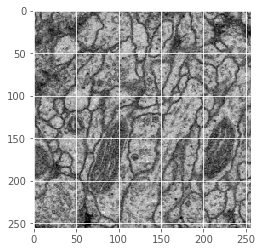

In [38]:
img = img_to_array(load_img("samples/cells.png", color_mode = "grayscale"))
img = resize(img, (im_width, im_height, 1), mode = 'constant', preserve_range = True)
plt.imshow(img[..., 0], cmap='gray')

In [39]:
prediction = model.predict(img[np.newaxis, ...])[0, ..., 0]

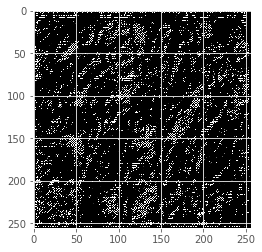

In [40]:
plt.imshow(prediction * 255, cmap='gray')